In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

plt.style.use('fivethirtyeight')
# Add project directory to kernel paths
sys.path.append('../../')

In [2]:
from src.data.file_manager import FileManager
weatherManager = FileManager()
color_pal = sns.color_palette()

In [3]:
raw_dir_path = weatherManager.data_dir / 'raw'

raw_path = str(raw_dir_path / 'raw_data.csv')
df_final = pd.read_csv(raw_path)
df_final.set_index("index" , inplace=True)

#on rename index par Year
df_final = df_final.rename(columns={'index': 'Year'})
df_final


,AverageTemperature
index,
2000,11.738083
2001,11.361583
2002,11.767500
2003,12.076917
2004,11.266333
2005,11.229083
2006,11.871250
2007,11.571833
2008,11.200750


<Axes: title={'center': 'Temperature over Time (Every year)'}, xlabel='index'>

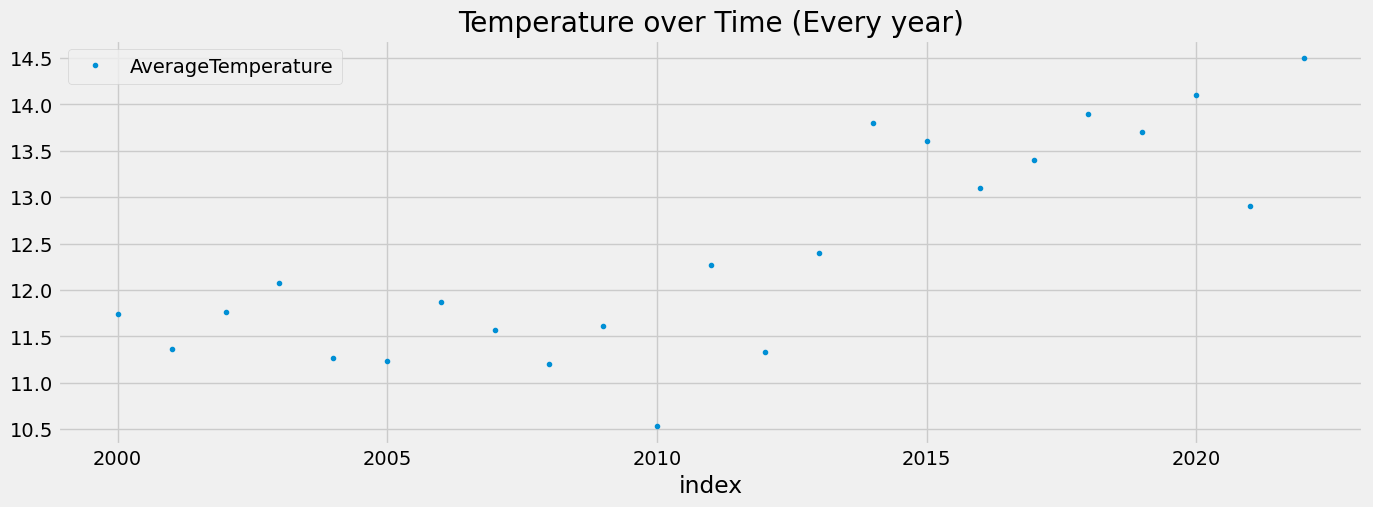

In [4]:
df_final.plot(style='.', figsize=(15,5), color=color_pal[0], title='Temperature over Time (Every year)')

Train / Test Split

In [5]:
df_filtered = []
for i in range(0,23):
    timestamp = pd.Timestamp(df_final.index[i], 1, 1)
    df_filtered.append(timestamp)
df_filtered
df_filtered = pd.to_datetime(df_filtered)
df_filtered

DatetimeIndex(['2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
               '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
               '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01',
               '2020-01-01', '2021-01-01', '2022-01-01'],
              dtype='datetime64[ns]', freq=None)

In [6]:
df_final['Years'] = df_filtered
df_final.set_index("Years" , inplace=True)
df_final

,AverageTemperature
Years,
2000-01-01,11.738083
2001-01-01,11.361583
2002-01-01,11.767500
2003-01-01,12.076917
2004-01-01,11.266333
2005-01-01,11.229083
2006-01-01,11.871250
2007-01-01,11.571833
2008-01-01,11.200750


In [7]:
raw_dir_path = weatherManager.data_dir / 'raw'
print(raw_dir_path)

raw_path = str(raw_dir_path / 'full_data.csv')
df_final = df_final.reset_index()
df_final.to_csv(raw_path, index=False)

/home/dylan/Desktop/IA_Voltron/voltron_ia/notebooks/dataprocessing/../../data/raw


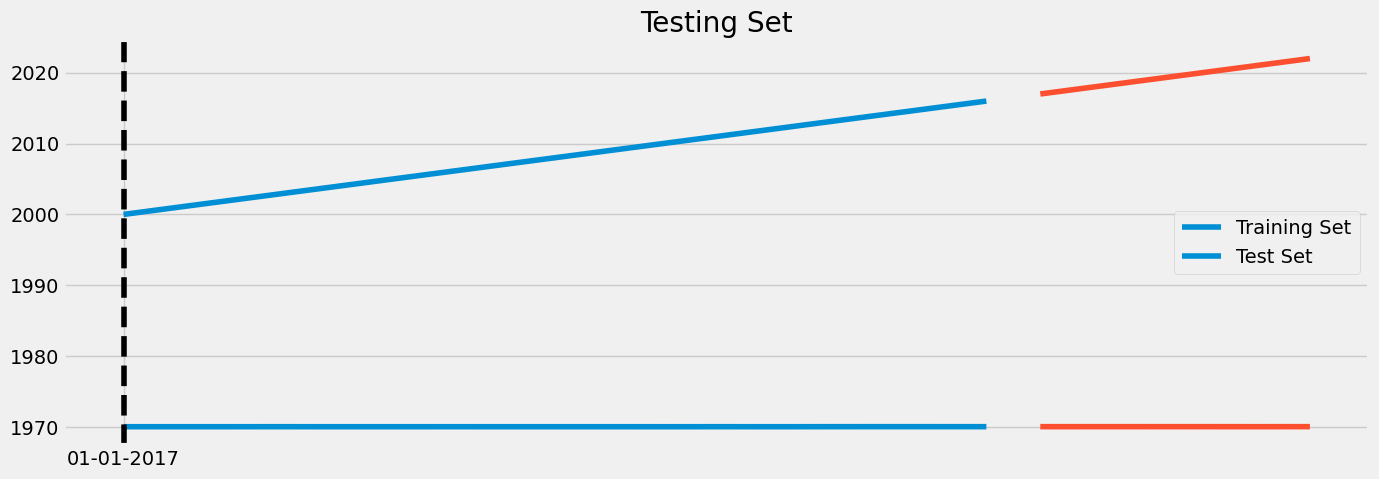

In [8]:
train = df_final.loc[df_filtered < '2017']
test = df_final.loc[df_filtered >= '2017']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, color=color_pal[0], label='Training Set',  title='Training Set')
test.plot(ax=ax, color=color_pal[1], label='Testing Set',  title='Testing Set')
ax.axvline('01-01-2017', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()


Create Time Series based on time series index
Feature Creation

In [9]:
# def create_feature(df_final):
#     df_final['hour'] = df_filtered.hour
#     df_final['dayofweek'] = df_filtered.dayofweek
#     df_final['quarter'] = df_filtered.quarter
#     df_final['month'] = df_filtered.month
#     df_final['year'] = df_filtered.year
#     df_final['dayofyear'] = df_filtered.dayofyear
#     return df_final
# df_final
    

VIsualize our Feature / Target Relationship

Text(0.5, 1.0, 'Temperature by Year')

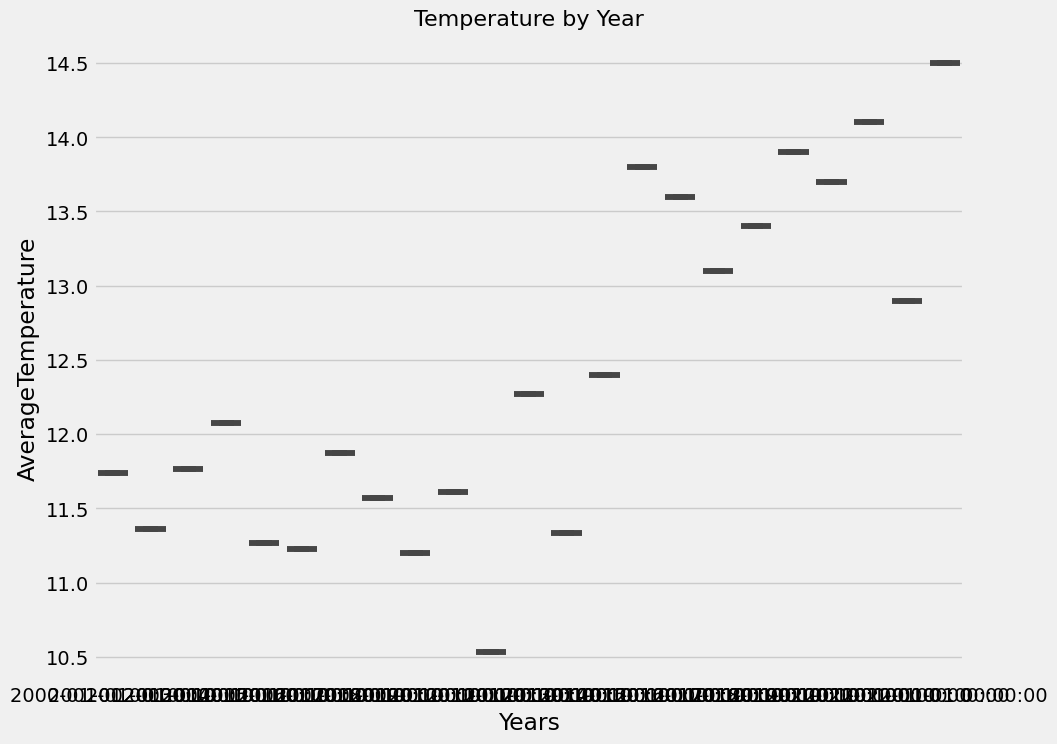

In [10]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df_final, x='Years', y='AverageTemperature', ax=ax)
ax.set_title('Temperature by Year', fontsize=16)

Create our model

In [11]:
train = create_feature(train)
test = create_feature(test) 
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Temperature'

NameError: name 'create_feature' is not defined

In [ ]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
        )

Feature Importance

In [ ]:
fi = pd.DataFrame(data= reg.feature_importances_,
             index= reg.feature_names_in_,
             columns=['importance']
             )

In [ ]:
fi.sort_values(by='importance', ascending=True).plot(kind='barh', figsize=(10,8))
fi.plt.show()

Forecast on Test

In [ ]:
df_final.merge(test, how='left', left_index=True, right_index=True)[['Temperature_x', 'Temperature_y']].plot(figsize=(15,5))

In [ ]:
test['prediction'] = reg.predict(X_test)
df_final.merge(test, how='left', left_index=True, right_index=True)[['Temperature_x', 'Temperature_y']].plot(figsize=(15,5))
ax = df_final[['Temperature']].plot(figsize=(15,5))
df_final[['Temperature']].plot(ax=ax, style='.')
ax.set_title('Temperature over Time (Every 10 Minutes)')
df_final.plt.show()


In [ ]:
score = np.sqrt(mean_squared_error(test['Temperature'], test['prediction']))
print(f'RMSE: Score on the Test set: {score:0.2f}')

Calculate Error

In [ ]:
test['error'] =  np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

Next Steps
- More robust cross validation
- Add more Features